# Business Cycle - Interest Rates

## Imports

In [30]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import pmp_functions_v5 as pmp
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

path = "../../Data_Ryan"

## Global Variables

In [31]:
frequency = 1
t_cost = 0
target_vol = 0.10
min_regions = 4
lag_months = 3

## Data

### Riskfree Data

In [32]:
# --- Load Riskfree Rate ---
factors_data = pd.read_excel(
    f"{path}/Factors.xlsx",
    index_col = 0,
    parse_dates = True
)

factors_data.index = pd.to_datetime(factors_data.index, format='%Y%m')
factors_data.index = factors_data.index + pd.offsets.MonthEnd(0)
factors_data /= 100

riskfree = factors_data["RF"].resample('ME').last()
display(riskfree)

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_92004/711168680.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  factors_data = pd.read_excel(


1926-07-31    0.0022
1926-08-31    0.0025
1926-09-30    0.0023
1926-10-31    0.0032
1926-11-30    0.0031
               ...  
2025-06-30    0.0034
2025-07-31    0.0034
2025-08-31    0.0038
2025-09-30    0.0033
2025-10-31    0.0037
Freq: ME, Name: RF, Length: 1192, dtype: float64

### Factor Data

In [33]:
# --- Load Factors Data ---
famafrench_data = pd.read_csv(
    f"{path}/famafrench_factors.csv",
    index_col = 0,
    parse_dates = True
)

famafrench_data.index = pd.to_datetime(famafrench_data.index, format='%Y%m')
famafrench_data.index = famafrench_data.index + pd.offsets.MonthEnd(0)
famafrench_data.dropna(inplace=True)
famafrench_data

/var/folders/bl/ywj9s7j57_qf7pwls_sv_w9r0000gn/T/ipykernel_92004/297690613.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  famafrench_data = pd.read_csv(


,MKT-RF,SMB,HML,RMW,CMA,UMD,BAB
DATE,,,,,,,
1980-01-31,0.0550,0.0188,0.0185,-0.0184,0.0189,0.0745,0.0695
1980-02-29,-0.0123,-0.0162,0.0059,-0.0095,0.0292,0.0789,-0.0132
1980-03-31,-0.1289,-0.0697,-0.0096,0.0182,-0.0105,-0.0958,-0.1181
1980-04-30,0.0396,0.0105,0.0103,-0.0218,0.0034,-0.0048,0.0574
1980-05-31,0.0526,0.0200,0.0038,0.0043,-0.0063,-0.0118,0.0618
...,...,...,...,...,...,...,...
2025-05-31,0.0606,-0.0072,-0.0288,0.0129,0.0251,0.0221,0.0256
2025-06-30,0.0486,-0.0002,-0.0160,-0.0320,0.0145,-0.0264,0.0527
2025-07-31,0.0198,-0.0015,-0.0127,-0.0029,-0.0208,-0.0096,0.0184


### Benchmark Data

In [34]:
# --- Benchmark Data ---
benchmark_data = pd.read_excel(
    f"{path}/Benchmarks.xlsx",
    index_col = 0,
    parse_dates = True
)

benchmark_data.index = pd.to_datetime(benchmark_data.index)
benchmark_data = benchmark_data.resample('ME').last()
display(benchmark_data)

benchmark_TR = benchmark_data[['60/40']].pct_change()
benchmark_XR = benchmark_TR.sub(riskfree, axis = 0)

benchmark_TR.columns = ['Benchmark Total Return']
benchmark_XR.columns = ['Benchmark Excess Return']
benchmark_returns = pd.concat([benchmark_TR, benchmark_XR], axis = 1).dropna()

display(benchmark_returns)

benchmark_TR = benchmark_TR.squeeze()

,S&P 500,MSCI World,FTSE WGBI,60/40
Date,,,,
1986-12-31,242.1700,NaN,156.5737,14.640989
1987-01-31,274.7800,NaN,161.2733,15.080442
1987-02-28,285.6377,NaN,163.7959,15.316327
1987-03-31,293.8792,NaN,167.5858,15.670715
1987-04-30,291.2698,NaN,169.5120,15.850831
...,...,...,...,...
2025-07-31,14412.5527,8214.1572,899.0753,418.585408
2025-08-31,14704.7217,8431.0801,911.3233,428.564691
2025-09-30,15240.0381,8705.7139,916.8774,440.268260


,Benchmark Total Return,Benchmark Excess Return
1987-01-31,0.030015,0.025815
1987-02-28,0.015642,0.011342
1987-03-31,0.023138,0.018438
1987-04-30,0.011494,0.007094
1987-05-31,-0.009907,-0.013707
...,...,...
2025-06-30,0.038273,0.034873
2025-07-31,0.006737,0.003337
2025-08-31,0.023840,0.020040
2025-09-30,0.027309,0.024009


### Macro Data

In [35]:
# --- Load Macro Data ---
rgdp_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'RGDP',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

cpi_data = pd.read_excel(
    f"{path}/Macro Data.xlsx",
    sheet_name = 'CPI',
    index_col='Date', # Use the column name 'Date' for the index
    parse_dates=True
)

# --- Align and Forward-Fill RGDP Data ---

# Get the monthly index from the CPI data
monthly_index = cpi_data.index

# Reindex the quarterly RGDP data to the monthly frequency.
# This introduces NaN values for the months that are not the start of a quarter.
rgdp_monthly = rgdp_data.reindex(monthly_index)

# Forward-fill (ffill) the NaN values.
# This carries the quarterly value forward to the subsequent two months.
rgdp_ffilled = rgdp_monthly.ffill()

rgdp_ffilled.index = rgdp_ffilled.index + pd.offsets.MonthEnd(0)

# Adjust the CPI DataFrame index to month-end
cpi_data.index = cpi_data.index + pd.offsets.MonthEnd(0)

# --- Final DataFrames ---
rgdp_final = rgdp_ffilled
cpi_final = cpi_data

display(rgdp_final)
display(cpi_final)

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-02-28,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-03-31,0.525515,8.3,NaN,NaN,13.4,NaN,NaN
1970-04-30,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
1970-05-31,-0.247900,8.3,NaN,NaN,10.8,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-08-31,3.500000,2.1,1.3,0.5,1.1,1.4,4.8
2025-09-30,3.500000,2.1,1.3,0.5,1.1,1.4,4.8


,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1970-01-31,6.162465,NaN,4.9,2.3,NaN,NaN,NaN
1970-02-28,6.424581,NaN,4.9,2.1,NaN,NaN,NaN
1970-03-31,6.094183,2.1,5.0,2.5,NaN,NaN,NaN
1970-04-30,6.060606,2.1,5.4,2.6,NaN,NaN,NaN
1970-05-31,6.043956,2.1,5.7,3.1,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,2.731801,2.1,3.8,0.2,3.1,2.0,0.0
2025-08-31,2.939220,2.1,3.8,0.2,2.7,2.0,-0.4
2025-09-30,3.022700,3.2,3.8,0.2,2.9,2.2,-0.3


### Interest Rate Data

In [36]:
# --- Load Interest Rate Futures ---
interest_futures = pd.read_excel(
    f"{path}/Interest Rates Data.xlsx",
    index_col = 0,
    parse_dates = True
)
interest_futures.index = pd.to_datetime(interest_futures.index)
interest_futures.index = interest_futures.index + pd.offsets.MonthEnd(0)

display("Interest Rate Futures:")
display(interest_futures)

'Interest Rate Futures:'

,CH,EU,AU,US,EM,UK,JP
Date,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,94.564,NaN,97.169,95.44,77.41,NaN,98.3323
1998-03-31,94.334,NaN,97.251,95.49,78.42,NaN,98.4613
1998-04-30,94.286,NaN,97.180,95.47,79.49,NaN,98.4910
1998-05-31,94.286,NaN,97.221,95.40,78.30,NaN,98.5456
...,...,...,...,...,...,...,...
2025-07-31,100.732,98.015,96.680,99.27,97.94,97.65,99.4600
2025-08-31,100.732,97.970,96.660,99.27,96.99,97.38,99.4600
2025-09-30,100.732,97.975,96.490,99.27,96.60,97.26,99.4600


In [37]:
# --- Interest Rate Returns ---
interest_XR = interest_futures.pct_change()
interest_XR = interest_XR.resample('ME').last()

display(interest_XR)

,CH,EU,AU,US,EM,UK,JP
Date,,,,,,,
1998-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-03-31,-0.002432,NaN,0.000844,0.000524,0.013047,NaN,0.001312
1998-04-30,-0.000509,NaN,-0.000730,-0.000209,0.013644,NaN,0.000302
1998-05-31,0.000000,NaN,0.000422,-0.000733,-0.014970,NaN,0.000554
...,...,...,...,...,...,...,...
2025-07-31,0.000000,-0.001019,-0.002281,0.000000,0.000000,-0.001840,0.000000
2025-08-31,0.000000,-0.000459,-0.000207,0.000000,-0.009700,-0.002765,0.000000
2025-09-30,0.000000,0.000051,-0.001759,0.000000,-0.004021,-0.001232,0.000000


## Signal Generation

In [38]:
# --- Compute Business Cycle Signal ---
rgdp_component = rgdp_final.diff(12).loc['1980-01-31':]

display("YoY change in RGDP:")
display(rgdp_component.tail(10))

# # Reindex RGDP trend to match CPI trend index exactly
# RGDP_component = RGDP_trend.reindex(CPI_trend.index).ffill()
# CPI_component = CPI_trend

'YoY change in RGDP:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-03-31,-0.919374,0.3,1.4,2.3,2.9,1.1,0.1
2025-04-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-05-31,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-06-30,-1.132658,1.1,0.5,-0.6,3.0,1.1,0.5
2025-07-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-08-31,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-09-30,0.842950,1.3,-0.1,-1.5,0.6,0.4,0.2
2025-10-31,1.016180,0.8,-0.6,-1.0,0.1,0.1,-0.6


In [39]:
cpi_component = cpi_final.diff(12).loc['1980-01-31':]

display("YoY change in CPI:")
display(cpi_component.tail(10))

'YoY change in CPI:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
2025-02-28,-0.351473,-1.7,-0.6,-0.9,0.9,-0.3,-1.4
2025-03-31,-1.069546,-1.2,-0.6,-0.7,0.9,-0.2,-0.2
2025-04-30,-1.023985,-1.2,1.2,-1.4,1.1,-0.2,-0.4
2025-05-31,-0.874276,-1.2,1.4,-1.5,0.7,-0.7,-0.4
2025-06-30,-0.302945,-1.7,1.6,-1.2,0.5,-0.5,-0.1
2025-07-31,-0.191765,-1.7,1.6,-1.1,0.3,-0.6,-0.5
2025-08-31,0.347993,-1.7,1.6,-0.9,-0.3,-0.2,-1.0
2025-09-30,0.615186,0.4,2.1,-0.6,0.4,0.5,-0.7
2025-10-31,0.446374,0.4,1.3,-0.5,0.7,0.1,-0.1


In [40]:
# --- Composite Signal Construction ---
# Logic: For Interest Rates, we want Low Growth (-) and Low Inflation (-)
# We combine them: 50% Growth, 50% Inverse Inflation
business_cyle_signal = - (0.5 * rgdp_component) - (0.5 * cpi_component)
business_cyle_signal = business_cyle_signal.resample('ME').last()

display("Business Cycle Signal:")
display(business_cyle_signal)

'Business Cycle Signal:'

,US,AU,UK,CH,JP,EU,EM
Date,,,,,,,
1980-01-31,-0.454643,0.85,-4.080588,NaN,-0.70,NaN,NaN
1980-02-29,-0.305826,0.85,-4.330588,NaN,-1.75,NaN,NaN
1980-03-31,-0.315491,0.95,-4.580588,NaN,-1.80,NaN,NaN
1980-04-30,-0.802019,-1.25,0.260002,NaN,-0.80,NaN,NaN
1980-05-31,-0.614016,-1.25,0.310002,NaN,-0.60,NaN,NaN
...,...,...,...,...,...,...,...
2025-07-31,-0.325593,0.20,-0.750000,1.30,-0.45,0.10,0.15
2025-08-31,-0.595471,0.20,-0.750000,1.20,-0.15,-0.10,0.40
2025-09-30,-0.729068,-0.85,-1.000000,1.05,-0.50,-0.45,0.25


## Portfolio Construction

In [41]:
# --- Compute Weights ---
weights, scaling_factors, weights_raw = pmp.make_country_weights_ls_vol(
    signal=business_cyle_signal,
    returns= interest_XR,
    min_regions=min_regions,
    signal_lag= lag_months,
    vol_target=target_vol,
    vol_lookback=24
)

In [42]:
display(weights_raw)
display(weights)

,US,AU,UK,CH,JP,EU,EM
1998-02-28,-0.415900,0.103975,NaN,-1.455651,0.623850,NaN,1.143726
1998-03-31,0.103975,-0.415900,NaN,-1.455651,0.623850,NaN,1.143726
1998-04-30,0.249136,-0.581318,NaN,-1.411773,0.664364,NaN,1.079591
1998-05-31,0.249136,-0.581318,NaN,-1.411773,0.664364,NaN,1.079591
1998-06-30,0.249136,-0.581318,NaN,-1.411773,0.664364,NaN,1.079591
...,...,...,...,...,...,...,...
2025-06-30,1.388730,0.925820,0.00000,-0.925820,-1.388730,-0.46291,0.462910
2025-07-31,1.388730,0.462910,-0.92582,0.925820,-1.388730,-0.46291,0.000000
2025-08-31,0.925820,0.462910,-0.92582,1.388730,-1.388730,-0.46291,0.000000
2025-09-30,0.925820,0.462910,-0.92582,1.388730,-1.388730,-0.46291,0.000000


,US,AU,UK,CH,JP,EU,EM
2000-01-31,-0.104613,0.523064,NaN,-1.987644,1.150742,-1.359967,1.778419
2000-02-29,-0.104591,0.522954,NaN,-1.987224,1.150498,-1.359679,1.778042
2000-03-31,-0.623591,0.623591,NaN,-1.870774,1.247183,-1.247183,1.870774
2000-04-30,0.107434,2.041250,NaN,-1.826382,-0.537171,-1.181776,1.396645
2000-05-31,0.109481,2.080139,NaN,-1.861177,-1.204291,-0.547405,1.423253
...,...,...,...,...,...,...,...
2025-06-30,3.525721,2.350481,0.000000,-2.350481,-3.525721,-1.175240,1.175240
2025-07-31,3.776858,1.258953,-2.517905,2.517905,-3.776858,-1.258953,0.000000
2025-08-31,2.508249,1.254125,-2.508249,3.762374,-3.762374,-1.254125,0.000000
2025-09-30,2.606569,1.303284,-2.606569,3.909853,-3.909853,-1.303284,0.000000


## Backtest

In [43]:
results = pmp.run_cc_strategy(
    weights = weights,
    returns = interest_XR,
    rf = riskfree,
    frequency=1,
    t_cost= t_cost,
    benchmark = benchmark_TR
)

results

results.to_csv('macroBC_rates.csv')

## Performance Statistics

In [44]:
pmp.run_perf_summary_benchmark_vs_strategy(results, alreadyXs = True)

,Benchmark,Strategy
Arithm Avg Total Return,6.3113,-3.0121
Arithm Avg Xs Return,4.4759,-4.8474
Std Xs Returns,9.8089,12.6785
Sharpe Arithmetic,0.4563,-0.3823
Geom Avg Total Return,5.9894,-3.7752
Geom Avg Xs Return,4.1402,-5.6244
Sharpe Geometric,0.4221,-0.4436
Min Xs Return,-10.2114,-20.7389
Max Xs Return,8.6715,12.4164
Skewness,-0.4323,-1.2060


## Plots

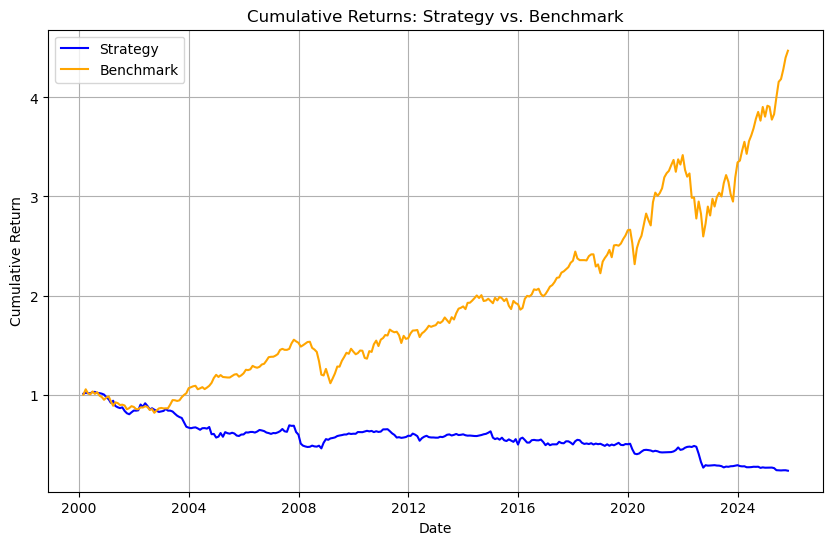

In [45]:
plt.figure(figsize=(10, 6))
plt.plot((1 + results["ret_net"]).cumprod(), label="Strategy", color="blue")
plt.plot((1 + results["ret_bm"]).cumprod(), label="Benchmark", color="orange")
plt.title("Cumulative Returns: Strategy vs. Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
#make the y-axis logarithmic
#plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()